# India Air Quality Data - EDA

## 📝 Problem Statement:
Air pollution is one of the most pressing global environmental challenges, directly impacting human health, ecosystems, and climate. Monitoring air quality helps policymakers and environmental agencies make informed decisions to control emissions and protect public health. In this project, we will explore global air quality datasets to identify pollution trends, seasonal variations, and city/country comparisons.

## 📁 Dataset

[🔗 Source: Air Quality Data in India (2015 - 2020)
 (Kaggle)](https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india)

# LIBRARIES IMPORT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# FILE UPLOAD

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASETS/INDIA AIR QUALITY DATA/city_day.csv', parse_dates=['Date']) # City wise per Day Data
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASETS/INDIA AIR QUALITY DATA/station_day.csv', parse_dates=['Date']) # Station wise per Day Data
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASETS/INDIA AIR QUALITY DATA/stations.csv') # Stations Data

In [ ]:
print(f"Rows in City wise per Day Data: {df1.shape[0]}")
print(f"Columns in City wise per Day Data: {df1.shape[1]}\n")
print(f"Rows in Station wise per Day Data: {df2.shape[0]}")
print(f"Columns in Station wise per Day Data: {df2.shape[1]}\n")
print(f"Rows in Stations Data: {df3.shape[0]}")
print(f"Columns in Stations Data: {df3.shape[1]}")

Rows in City wise per Day Data: 29531
Columns in City wise per Day Data: 16

Rows in Station wise per Day Data: 108035
Columns in Station wise per Day Data: 16

Rows in Stations Data: 230
Columns in Stations Data: 5


In [ ]:
print("Info of 'City wise per Day Data':\n")
df1.info()

print("\nInfo of 'Station wise per Day Data':\n")
df2.info()

print("\nInfo of 'Stations Data':\n")
df3.info()

Info of 'City wise per Day Data':

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  object        
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       24933 non-null  float64       
 3   PM10        18391 non-null  float64       
 4   NO          25949 non-null  float64       
 5   NO2         25946 non-null  float64       
 6   NOx         25346 non-null  float64       
 7   NH3         19203 non-null  float64       
 8   CO          27472 non-null  float64       
 9   SO2         25677 non-null  float64       
 10  O3          25509 non-null  float64       
 11  Benzene     23908 non-null  float64       
 12  Toluene     21490 non-null  float64       
 13  Xylene      11422 non-null  float64       
 14  AQI         24850 non-null  float64       
 15  AQI_Bucket  24850 non-null  object 

    Applying a hybrid imputation strategy to fill missing values in time-series data.

    This strategy consists of two steps:
    1.  Time-series Interpolation: Fills short, isolated gaps (controlled by `interpolation_limit`)
        on a per-group (city/station) basis. This is efficient for small gaps.
    2.  Multivariate Imputation: Uses the IterativeImputer to fill the remaining
        (typically longer) gaps by modeling the relationships between features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column to group the data by (e.g., 'City' or 'StationId').
        date_col (str): The date/time column.
        features (list): A list of the feature columns to be imputed.
        interpolation_limit (int): The maximum number of consecutive missing values to fill with time-series interpolation.

    Returns:
        pd.DataFrame: A DataFrame with missing values in the specified features imputed.


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def hybrid_imputation(df, group_col, date_col, features, interpolation_limit=7):

    df_imputed = df.copy()

    # --- Step 1: Time-series interpolation for short gaps ---

    # We group by city/station to ensure that we don't interpolate across different locations.
    def interpolate_group(g):
        # Ensure the data is sorted by date for correct time-based interpolation
        g = g.sort_values(date_col)
        # Set the date as the index to use the 'time' interpolation method
        g = g.set_index(date_col)
        # Apply interpolation, but only for short gaps up to the specified limit
        g[features] = g[features].interpolate(method="time", limit=interpolation_limit, limit_direction='both')
        # Use forward-fill and backward-fill to handle any remaining NaNs at the edges of the series
        g[features] = g[features].ffill().bfill()
        return g.reset_index()

    df_imputed = (
        df_imputed.groupby(group_col, group_keys=False)
                    .apply(interpolate_group)
                    .reset_index(drop=True)
    )

    # --- Step 2: Multivariate IterativeImputer for remaining long gaps ---

    # This imputer models each feature as a function of other features.
    if df_imputed[features].isnull().sum().sum() > 0:
        imputer = IterativeImputer(random_state=42, max_iter=10)
        df_imputed[features] = imputer.fit_transform(df_imputed[features])

    return df_imputed

# Define features to impute
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
            'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

# We'll use a limit of 7 days for interpolation. This is a tunable parameter.
df1_imputed = hybrid_imputation(df1, group_col="City", date_col="Date", features=features, interpolation_limit=7)
df2_imputed = hybrid_imputation(df2, group_col="StationId", date_col="Date", features=features, interpolation_limit=7)

print("Imputation complete. Here's a preview of the imputed city-level data:")
print(df1_imputed.head())


print("\nChecking for any remaining missing values in the city data:")
print(df1_imputed[features].isnull().sum())
print("\n", df2_imputed[features].isnull().sum())

/tmp/ipython-input-735336293.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(interpolate_group)
/tmp/ipython-input-735336293.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(interpolate_group)


Imputation complete. Here's a preview of the imputed city-level data:
        Date       City  PM2.5    PM10     NO    NO2    NOx        NH3     CO  \
0 2015-01-01  Ahmedabad  73.24  141.54   0.92  18.22  17.15  21.027522   0.92   
1 2015-01-02  Ahmedabad  73.24  141.54   0.97  15.69  16.46  19.784545   0.97   
2 2015-01-03  Ahmedabad  73.24  141.54  17.40  19.30  29.70  15.261771  17.40   
3 2015-01-04  Ahmedabad  73.24  141.54   1.70  18.48  17.97  14.896278   1.70   
4 2015-01-05  Ahmedabad  73.24  141.54  22.10  21.42  37.76  15.529142  22.10   

     SO2      O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  27.64  133.36     0.00     0.02    0.00  NaN        NaN  
1  24.55   34.06     3.68     5.50    3.77  NaN        NaN  
2  29.07   30.70     6.80    16.40    2.25  NaN        NaN  
3  18.59   36.08     4.43    10.14    1.00  NaN        NaN  
4  39.33   39.31     7.01    18.89    2.78  NaN        NaN  

Checking for any remaining missing values in the city data:
PM2.5      0
PM1

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
print("City Day Imputation Data Info: ")
df1_imputed.info()

print("\nStation Day Imputation Data Info: ")
df2_imputed.info()

City Day Imputation Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        29531 non-null  datetime64[ns]
 1   City        29531 non-null  object        
 2   PM2.5       29531 non-null  float64       
 3   PM10        29531 non-null  float64       
 4   NO          29531 non-null  float64       
 5   NO2         29531 non-null  float64       
 6   NOx         29531 non-null  float64       
 7   NH3         29531 non-null  float64       
 8   CO          29531 non-null  float64       
 9   SO2         29531 non-null  float64       
 10  O3          29531 non-null  float64       
 11  Benzene     29531 non-null  float64       
 12  Toluene     29531 non-null  float64       
 13  Xylene      29531 non-null  float64       
 14  AQI         24850 non-null  float64       
 15  AQI_Bucket  24850 non-null  object    

In [ ]:
# Replacing 'NaN' values with 0
df1_imputed['AQI'] = df1['AQI'].replace(np.nan, 0)
df1_imputed['AQI_Bucket'] = df1['AQI_Bucket'].replace(np.nan, 'Unknown')

#Replacing 'NaN' values with 'Unknown'
df2_imputed['AQI'] = df2['AQI'].replace(np.nan, 0)
df2_imputed['AQI_Bucket'] = df2['AQI_Bucket'].replace(np.nan, 'Unknown')

In [ ]:
df1_imputed.head(10)

,Date,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,2015-01-01,Ahmedabad,73.24,141.54,0.920,18.22,17.15,21.027522,0.920,27.64,133.36,0.00,0.02,0.00,0.0,Unknown
1,2015-01-02,Ahmedabad,73.24,141.54,0.970,15.69,16.46,19.784545,0.970,24.55,34.06,3.68,5.50,3.77,0.0,Unknown
2,2015-01-03,Ahmedabad,73.24,141.54,17.400,19.30,29.70,15.261771,17.400,29.07,30.70,6.80,16.40,2.25,0.0,Unknown
3,2015-01-04,Ahmedabad,73.24,141.54,1.700,18.48,17.97,14.896278,1.700,18.59,36.08,4.43,10.14,1.00,0.0,Unknown
4,2015-01-05,Ahmedabad,73.24,141.54,22.100,21.42,37.76,15.529142,22.100,39.33,39.31,7.01,18.89,2.78,0.0,Unknown
5,2015-01-06,Ahmedabad,73.24,141.54,45.410,38.48,81.50,22.024877,45.410,45.76,46.51,5.42,10.83,1.93,0.0,Unknown
6,2015-01-07,Ahmedabad,73.24,141.54,112.160,40.62,130.77,36.869373,112.160,32.28,33.47,0.00,0.00,0.00,0.0,Unknown
7,2015-01-08,Ahmedabad,73.24,141.54,80.870,36.74,96.75,29.959674,80.870,38.54,31.89,0.00,0.00,0.00,0.0,Unknown
8,2015-01-09,Ahmedabad,73.24,141.54,29.160,31.00,48.00,16.744156,29.160,58.68,25.75,0.00,0.00,0.00,0.0,Unknown
9,2015-01-10,Ahmedabad,73.24,141.54,80.615,7.04,0.00,29.247038,80.615,8.29,4.55,0.00,0.00,0.00,0.0,Unknown


In [ ]:
df2_imputed.head(10)

,Date,StationId,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,2017-11-24,AP001,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,0.0,Unknown
1,2017-11-25,AP001,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,2017-11-26,AP001,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,2017-11-27,AP001,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,2017-11-28,AP001,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate
5,2017-11-29,AP001,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,109.74,0.21,4.71,0.08,173.0,Moderate
6,2017-11-30,AP001,69.80,114.86,4.69,20.17,14.54,10.95,0.12,14.07,118.09,0.16,3.52,0.06,165.0,Moderate
7,2017-12-01,AP001,73.96,113.56,4.58,19.29,13.97,10.95,0.10,13.90,123.80,0.17,2.85,0.04,191.0,Moderate
8,2017-12-02,AP001,89.90,140.20,7.71,26.19,19.87,13.12,0.10,19.37,128.73,0.25,2.79,0.07,191.0,Moderate
9,2017-12-03,AP001,87.14,130.52,0.97,21.31,12.12,14.36,0.15,11.41,114.80,0.23,3.82,0.04,227.0,Poor


In [ ]:
df1_imputed.info()
df2_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        29531 non-null  datetime64[ns]
 1   City        29531 non-null  object        
 2   PM2.5       29531 non-null  float64       
 3   PM10        29531 non-null  float64       
 4   NO          29531 non-null  float64       
 5   NO2         29531 non-null  float64       
 6   NOx         29531 non-null  float64       
 7   NH3         29531 non-null  float64       
 8   CO          29531 non-null  float64       
 9   SO2         29531 non-null  float64       
 10  O3          29531 non-null  float64       
 11  Benzene     29531 non-null  float64       
 12  Toluene     29531 non-null  float64       
 13  Xylene      29531 non-null  float64       
 14  AQI         29531 non-null  float64       
 15  AQI_Bucket  29531 non-null  object        
dtypes: datetime64[ns](1), 

# Exploratory Data Analysis (EDA)

1. Which cities have the highest average AQI (Air Quality Index)?

In [ ]:
city_aqi = df1_imputed.groupby("City")["AQI"].mean().sort_values(ascending=False)
city_aqi.head(10)

,AQI
City,
Ahmedabad,300.215032
Delhi,258.196117
Lucknow,205.387257
Gurugram,194.821322
Patna,189.074812
Guwahati,138.157371
Jaipur,131.279174
Talcher,130.459459
Kolkata,130.205160


2. How does AQI vary by month or season?

In [ ]:
df1_imputed['Month'] = df1_imputed['Date'].dt.month
df1_imputed['Season'] = df1_imputed['Month']%12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall

monthly_aqi = df1_imputed.groupby("Month")["AQI"].mean()
seasonal_aqi = df1_imputed.groupby("Season")["AQI"].mean()

print(monthly_aqi)
print(seasonal_aqi)

Month
1     189.246852
2     171.606431
3     139.446708
4     121.761658
5     117.526764
6     100.229456
7      93.517760
8      92.771034
9      93.139439
10    157.441891
11    212.582917
12    194.589331
Name: AQI, dtype: float64
Season
1    185.117339
2    126.194632
3     95.918546
4    154.675004
Name: AQI, dtype: float64


3. What pollutants are recorded, and what are their average levels?

In [ ]:
pollutants = ['PM2.5','PM10','NO2','SO2','O3','CO']
pollutant_avgs = df1_imputed[pollutants].mean()
pollutant_avgs

,0
PM2.5,72.081934
PM10,126.160038
NO2,26.911053
SO2,22.463240
O3,33.424852
CO,2.377001


4. Which city has the cleanest air on average?

In [ ]:
cleanest_city = city_aqi.idxmin()
cleanest_city, city_aqi.min()

('Aizawl', 34.150442477876105)

5. Are there any missing data patterns in the dataset?

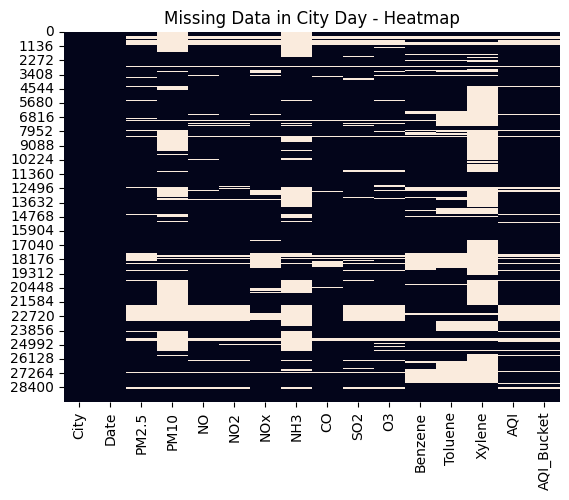

,0
City,0
Date,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
NH3,10328
CO,2059
SO2,3854


In [ ]:
city_missing_data = df1.isnull().sum()
sns.heatmap(df1.isnull(), cbar=False)
plt.title("Missing Data in City Day - Heatmap")
plt.show()

city_missing_data

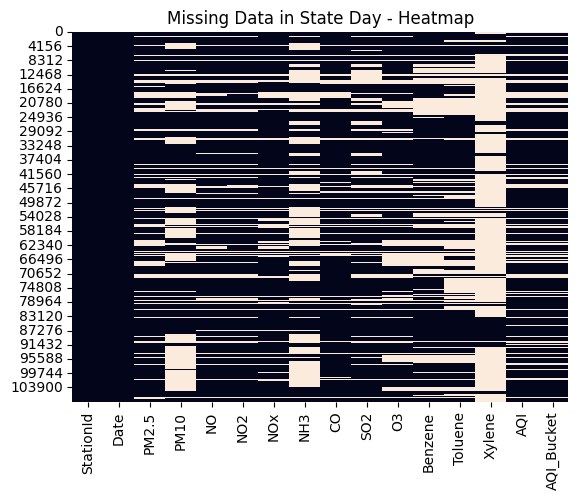

,0
StationId,0
Date,0
PM2.5,21625
PM10,42706
NO,17106
NO2,16547
NOx,15500
NH3,48105
CO,12998
SO2,25204


In [ ]:
state_missing_data = df2.isnull().sum()
sns.heatmap(df2.isnull(), cbar=False)
plt.title("Missing Data in State Day - Heatmap")
plt.show()

state_missing_data

6. Which cities consistently exceed safe pollution limits?

In [ ]:
limits = {'PM2.5':60, 'PM10':100, 'NO2':40, 'SO2':40, 'O3':100, 'CO':1.0}
exceed = {}

for pol, limit in limits.items():
    exceed[pol] = df1_imputed.groupby("City")[pol].apply(lambda x: (x > limit).mean()*100)

exceed_df = pd.DataFrame(exceed)
exceed_df.head()

,PM2.5,PM10,NO2,SO2,O3,CO
City,,,,,,
Ahmedabad,63.265306,91.538079,38.775510,57.391737,0.895968,95.171727
Aizawl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Amaravati,19.663512,26.708728,12.933754,0.736067,2.313354,11.146162
Amritsar,27.272727,49.877150,6.552007,1.146601,0.000000,12.285012
Bengaluru,9.805874,24.340468,14.484818,0.199104,0.298656,39.323046


7. How do pollution levels vary between weekdays and weekends?

In [ ]:
df1_imputed['Weekday'] = df1_imputed['Date'].dt.dayofweek
df1_imputed['DayType'] = np.where(df1_imputed['Weekday'] < 5, 'Weekday', 'Weekend')

weekday_aqi = df1_imputed.groupby("DayType")["AQI"].mean()
weekday_aqi

,AQI
DayType,
Weekday,140.553465
Weekend,138.885687


# Visualization

1. Bar chart of Top 10 most polluted cities by AQI.

/tmp/ipython-input-57274275.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Reds_r")


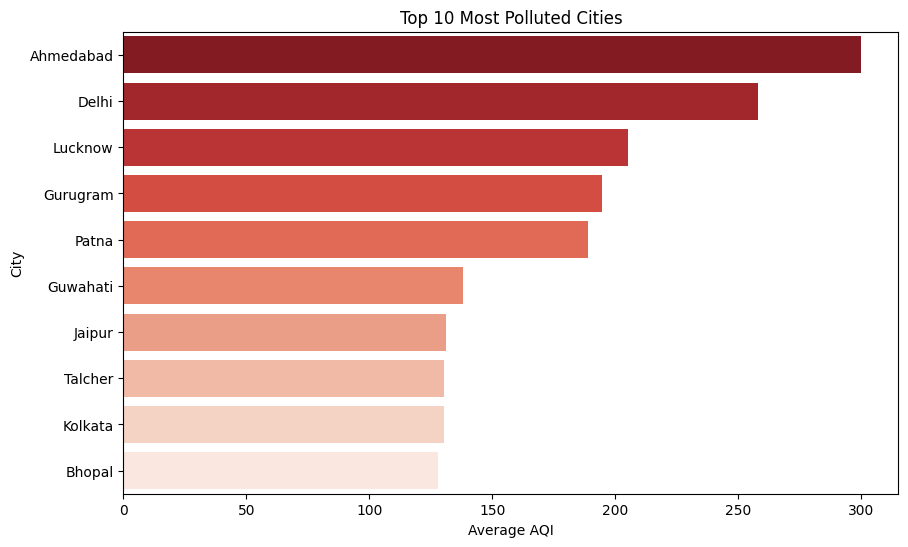

In [ ]:
top10 = city_aqi.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top10.values, y=top10.index, palette="Reds_r")
plt.xlabel("Average AQI")
plt.title("Top 10 Most Polluted Cities")
plt.show()

2. Line plot showing monthly AQI trends for selected cities.

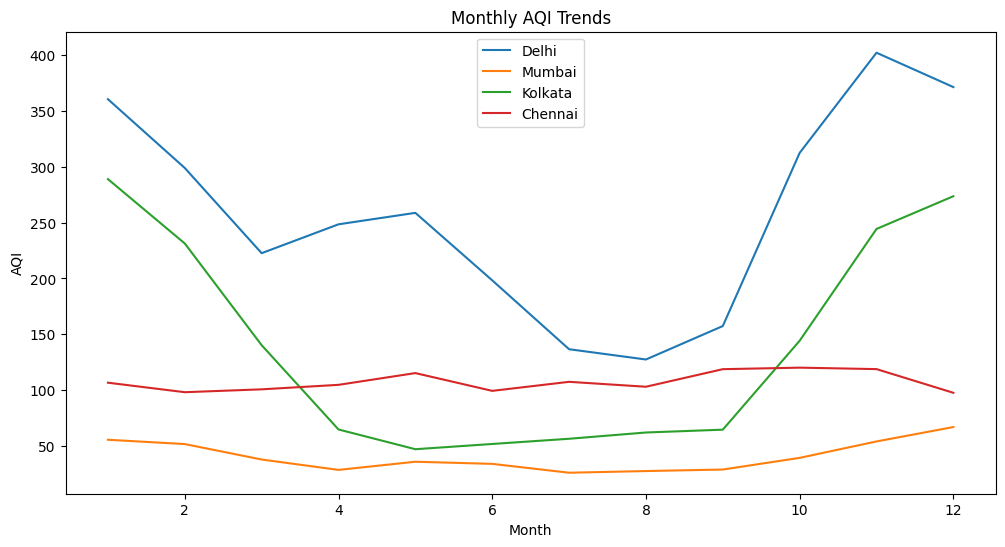

In [ ]:
selected_cities = ["Delhi", "Mumbai", "Kolkata", "Chennai"]
monthly_city_aqi = df1_imputed.groupby([df1_imputed['Month'], "City"])["AQI"].mean().reset_index()

plt.figure(figsize=(12,6))
for city in selected_cities:
    temp = monthly_city_aqi[monthly_city_aqi["City"]==city]
    plt.plot(temp["Month"], temp["AQI"], label=city)

plt.legend()
plt.title("Monthly AQI Trends")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.show()

3. Heatmap showing correlation between pollutants (PM2.5, PM10, NO2, SO2, O3, CO).

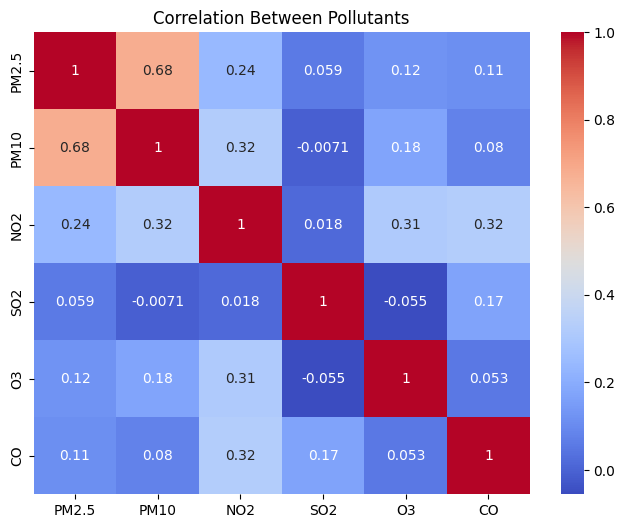

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df1_imputed[pollutants].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Pollutants")
plt.show()

4. Seasonal comparison plot of average AQI levels.

/tmp/ipython-input-3094966882.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Season", y="AQI", data=df1_imputed, estimator=np.mean,


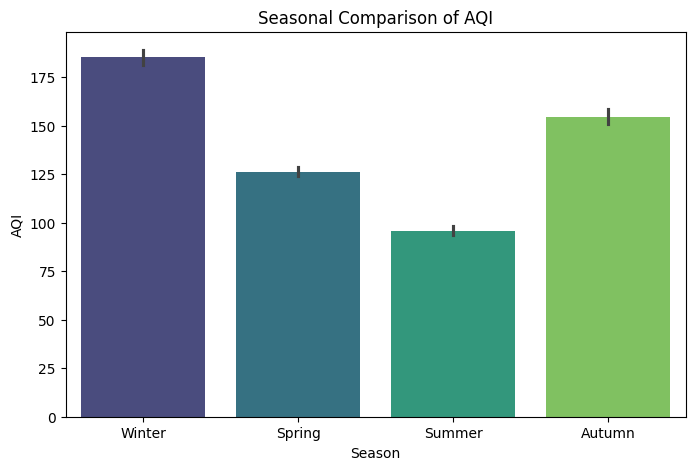

In [ ]:
# Extract month
df1_imputed['Month'] = df1_imputed['Date'].dt.month

# Proper month-to-season mapping
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:  # 9, 10, 11
        return "Autumn"

df1_imputed['Season'] = df1_imputed['Month'].apply(month_to_season)

# Seasonal AQI plot
plt.figure(figsize=(8,5))
sns.barplot(x="Season", y="AQI", data=df1_imputed, estimator=np.mean,
            order=["Winter", "Spring", "Summer", "Autumn"], palette="viridis")
plt.title("Seasonal Comparison of AQI")
plt.show()

5. Stacked bar chart of pollutant contributions in different cities.

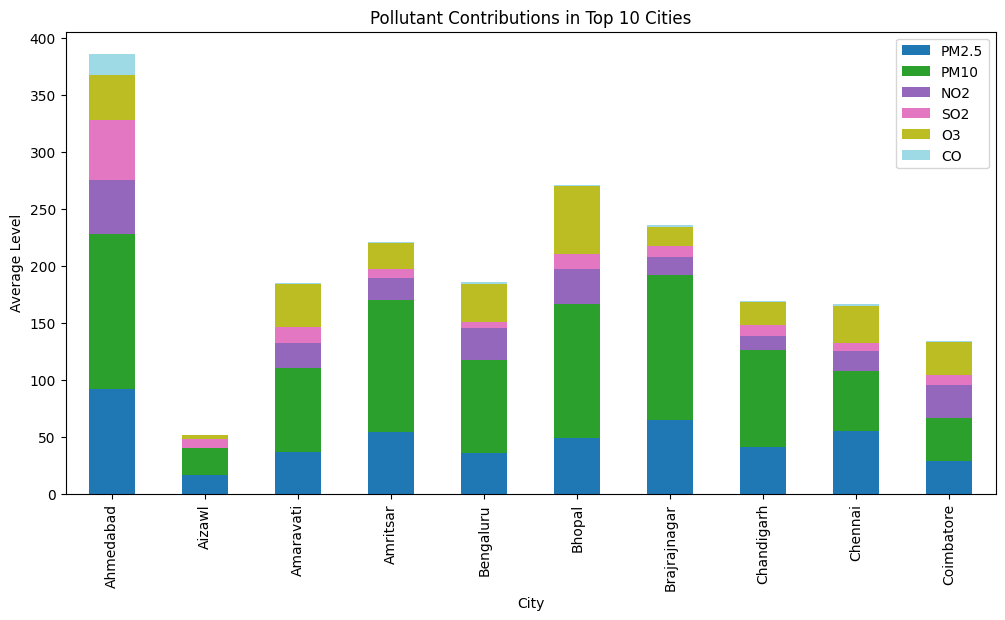

In [ ]:
pollutant_city_avg = df1_imputed.groupby("City")[pollutants].mean().head(10)

pollutant_city_avg.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.title("Pollutant Contributions in Top 10 Cities")
plt.ylabel("Average Level")
plt.show()

6. Map visualization showing geographic distribution of AQI values.

Step 1: Install & Import

In [ ]:
!pip install geopy

In [ ]:
from geopy.geocoders import Nominatim
import time

Step 2: Get Unique Cities from stations.csv

In [ ]:
cities = df3['City'].unique()
len(cities), cities[:10]

(127,
 array(['Amaravati', 'Rajamahendravaram', 'Tirupati', 'Vijayawada',
        'Visakhapatnam', 'Guwahati', 'Gaya', 'Hajipur', 'Muzaffarpur',
        'Patna'], dtype=object))

Step 3: Geocode Cities

In [ ]:
geolocator = Nominatim(user_agent="aqi_mapping")

city_coords = {}

for city in cities:
    try:
        location = geolocator.geocode(city + ", India")  # assuming Indian dataset
        if location:
            city_coords[city] = (location.latitude, location.longitude)
        else:
            city_coords[city] = (None, None)
        time.sleep(1)  # pause to avoid API rate limits
    except:
        city_coords[city] = (None, None)

Step 4: Create DataFrame with Coordinates

In [ ]:
city_coords_df = pd.DataFrame(city_coords).T.reset_index()
city_coords_df.columns = ['City', 'Latitude', 'Longitude']

Step 5: Merge with AQI Data

In [ ]:
# Average AQI per city
city_aqi = df2_imputed.merge(df3, on="StationId").groupby("City")["AQI"].mean().reset_index()

# Merge with coordinates
city_aqi_geo = city_aqi.merge(city_coords_df, on="City", how="left")

Step 6: Map Visualization

In [ ]:
import folium

m = folium.Map(location=[20, 80], zoom_start=5)

def get_color(aqi):
    if pd.isna(aqi):
        return "gray"
    elif aqi <= 50:
        return "green"
    elif aqi <= 100:
        return "yellow"
    elif aqi <= 200:
        return "orange"
    elif aqi <= 300:
        return "red"
    else:
        return "purple"

for _, row in city_aqi_geo.dropna().iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=7,
        color=get_color(row["AQI"]),
        fill=True,
        fill_color=get_color(row["AQI"]),
        popup=f"{row['City']}<br>AQI: {row['AQI']:.1f}"
    ).add_to(m)

m

7. Boxplot comparing AQI across major cities.

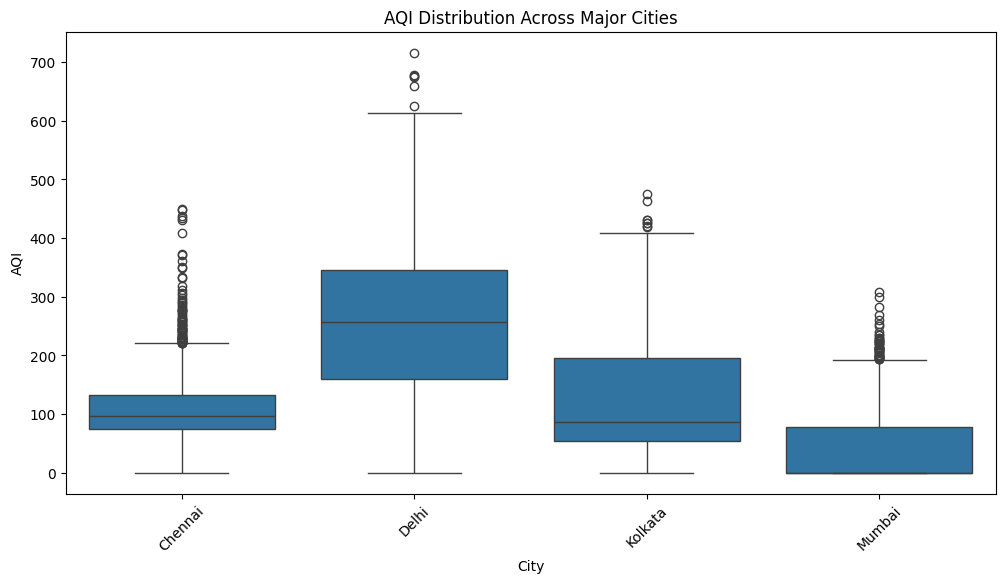

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x="City", y="AQI", data=df1_imputed[df1_imputed["City"].isin(selected_cities)])
plt.xticks(rotation=45)
plt.title("AQI Distribution Across Major Cities")
plt.show()